Main objectives are:

- 1) Average Time with error bars (Use SEM of Scipy method instead of the Std method used from the python) v/s the Number of qubits ('00'*value)
- 2) Generate similar graph for the general QAOA v/s the Number of qubits and then compare the graphs
- 3) Now consider the list of the tensors for both the general qaoa and the lcr mps qaoa  

1) Average Time with error bars
Let's say we are currently doing it for the qubit number 14

 Suppose we consider one graph and for which we will get an edgelist and that edgelist suppose has a 36 local nodes

ONE RUN:
 It will consist of one local node and we will do the circuit for 20 times
 now consider that we will use all the 36 local nodes so the total runtimes as of now would be 720


Now considering we will generate 10 graphs total data points for a single qubit value would be 7200, and we will generate the error bars for it

# Installations

In [ ]:
!pip install --quiet cotengra
!pip install --quiet kahypar
!pip install --quiet scikit_optimize
!pip install --quiet networkx
!pip install --quiet matplotlib
!pip install --quiet tqdm
!pip install --quiet quimb
#!pip install --quiet qiskit
#!pip install --quiet qiskit_aer

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 177.8/177.8 kB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 930.0/930.0 kB 27.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 18.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.8/107.8 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 27.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 73.6 MB/s eta 0:00:00


In [ ]:
import numpy as np
from numpy import linalg as LA
from numpy import pi

import quimb
import quimb.tensor as qtn

#import qiskit
#from qiskit import QuantumCircuit, transpile
#from qiskit_aer import Aer

import networkx as nx
import cotengra as ctg
import time
import tqdm

#The Functions

In case the imports doesn't work

In [ ]:
import numpy as np
import quimb as qtn
import quimb.tensor as qtn
import quimb

def Drop_Gates_LCRM(local_node, edgelist, num_layers, num_qubits):
    light_cone = set(local_node)
    excluded_gates_per_layer = []
    for layer in reversed(range(num_layers)):
        excluded_layer = []
        new_light_cone = set()
        for q1, q2 in edgelist:
            if q1 in light_cone or q2 in light_cone:
                new_light_cone.update([q1, q2])
            else:
                excluded_layer.append(f'RZZ({q1}, {q2})')
        for q in range(num_qubits):
            if q not in light_cone:
                excluded_layer.append(f'RX({q})')
        light_cone.update(new_light_cone)
        excluded_gates_per_layer.append(excluded_layer)
    return excluded_gates_per_layer[::-1]

import numpy as np

def rzz(gamma):
    return np.diag(np.array([np.exp(-1.j * gamma) / 2, np.exp(-1.j * gamma) / 2,
                             np.exp(-1.j * gamma) / 2, -np.exp(-1.j * gamma) / 2]))


def lcr_qaoa_mps(binary, layer_of_QAOA, filtered_gates, contract_value_sq, contract_value_tq, gamma, beta):
    q = qtn.MPS_computational_state(binary, dtype='float64', cyclic=False)
    n = len(binary)
    H = quimb.hadamard()

    # Apply Hadamard gates
    for i in range(n):
        q.gate_(H, i, tags=f'H_{i}', contract=contract_value_sq)

    # Apply QAOA layers with filtered gates
    for l in range(layer_of_QAOA):
        for gate in filtered_gates:
            if gate[2] == l:
                if gate[0] == 'RZZ':
                    i, j, layer = gate[1][0], gate[1][1], gate[2]
                    RZZ_gamma = rzz(gamma[layer])
                    q.gate_(RZZ_gamma, (i, j), tags=f'RZZ_{i}_{j}_L{layer}', contract=contract_value_tq)
                elif gate[0] == 'RX':
                    i, layer = gate[1], gate[2]
                    RX_beta = quimb.Rx(beta[layer])
                    q.gate_(RX_beta, i, tags=f'RX_{i}_L{layer}', contract=contract_value_tq)
    return q


import numpy as np
import time
import quimb

def rzz(gamma):
    return np.diag(np.array([np.exp(-1.j * gamma) / 2, np.exp(-1.j * gamma) / 2,
                             np.exp(-1.j * gamma) / 2, -np.exp(-1.j * gamma) / 2]))

#CHANGED THE NUM RUNS FROM 20 TO 5 so that it can run a bit faster
def lcr_qaoa_mps_run(binary, layer_of_QAOA, edgelist, num_runs=5):
    n = len(binary)
    runtime_data = []  # This stores the runtime information for each run
    gamma = [np.random.rand() for _ in range(layer_of_QAOA)]
    beta = [np.random.rand() for _ in range(layer_of_QAOA)]
    ZZ = quimb.pauli('Z') & quimb.pauli('Z')

    for local_node in edgelist:
        filtered_gates = []
        excluded_gates = Drop_Gates_LCRM(local_node, edgelist, layer_of_QAOA, n)

        for layer in range(layer_of_QAOA):
            RZZ_gamma = rzz(gamma[layer])
            RX_beta = quimb.Rx(beta[layer])

            gates_list = []
            for (i, j) in edgelist:
                gates_list.append(('RZZ', (i, j), layer))
            for i in range(n):
                gates_list.append(('RX', i, layer))

            for gate in gates_list:
                is_excluded = False
                for layer_idx, excluded_layer in enumerate(excluded_gates):
                    if gate[0] == 'RZZ' and f'RZZ({gate[1][0]}, {gate[1][1]})' in excluded_layer and gate[2] == layer_idx:
                        is_excluded = True
                    elif gate[0] == 'RX' and f'RX({gate[1]})' in excluded_layer and gate[2] == layer_idx:
                        is_excluded = True
                if not is_excluded:
                    filtered_gates.append(gate)

        elapsed_times = []
        for _ in range(num_runs):
            start_time = time.time()
            q = lcr_qaoa_mps(binary, layer_of_QAOA, filtered_gates, True, 'swap+split', gamma, beta)
            q.local_expectation_exact(ZZ, (local_node[0], local_node[1]), optimize=None)
            elapsed_time = time.time() - start_time
            elapsed_times.append(elapsed_time)

        runtime_data.append({'qubits': n, 'times': elapsed_times})

    return runtime_data



def regular_qaoa_mps_run(binary, layer_of_QAOA, edgelist, num_runs=20):
    n = len(binary)
    runtime_data = []

    gamma = [np.random.rand() for _ in range(layer_of_QAOA)]
    beta = [np.random.rand() for _ in range(layer_of_QAOA)]
    ZZ = quimb.pauli('Z') & quimb.pauli('Z')
    H = quimb.hadamard()

    for local_node in edgelist:
        elapsed_times = []

        for _ in range(num_runs):
            start_time = time.time()

            p = qtn.MPS_computational_state(binary, dtype='float64', cyclic=False)

            for i in range(n):
                p.gate_(H, i, tags=f'H_{i}', contract=True)

            for layer in range(layer_of_QAOA):
                RZZ_gamma = rzz(gamma[layer])
                RX_beta = quimb.Rx(beta[layer])

                for i, j in edgelist:
                    p.gate_(RZZ_gamma, (i, j), tags=f'RZZ_{i}_{j}_L{layer}', contract='swap+split')

                for i in range(n):
                    p.gate_(RX_beta, i, tags=f'RX_{i}_L{layer}', contract=True)

            p.local_expectation_exact(ZZ, (local_node[0], local_node[1]), optimize=None)

            elapsed_time = time.time() - start_time
            elapsed_times.append(elapsed_time)

        runtime_data.append({'local_node': local_node, 'qubits': n, 'times': elapsed_times})

    return runtime_data




#FOR THE USECASE OF THE DROPPED TENSOR COUNTS

#For the modified

def lcr_qaoa_mps_tensor(binary, layer_of_QAOA, filtered_gates, gamma, beta):
    """Construct QAOA circuit for a given set of filtered gates."""
    q = qtn.MPS_computational_state(binary, dtype='float64', cyclic=False)
    n = len(binary)
    H = quimb.hadamard()

    # Apply Hadamard gates
    for i in range(n):
        q.gate_(H, i, tags=f'H_{i}', contract=False)

    # Apply QAOA layers with filtered gates
    for l in range(layer_of_QAOA):
        for gate in filtered_gates:
            if gate[2] == l:
                if gate[0] == 'RZZ':
                    i, j = gate[1]
                    RZZ_gamma = rzz(gamma[l])
                    q.gate_(RZZ_gamma, (i, j), tags=f'RZZ_{i}_{j}_L{l}', contract=False)
                elif gate[0] == 'RX':
                    i = gate[1]
                    RX_beta = quimb.Rx(beta[l])
                    q.gate_(RX_beta, i, tags=f'RX_{i}_L{l}', contract=False)

    return q

#For the modified mps qaoa
def count_tensors_per_local_node(binary, layer_of_QAOA, edgelist):
    """Count tensors for each local node in the edge list."""
    n = len(binary)
    gamma = [np.random.rand() for _ in range(layer_of_QAOA)]
    beta = [np.random.rand() for _ in range(layer_of_QAOA)]

    tensor_counts = {}
    for local_node in edgelist:
        filtered_gates = []
        excluded_gates = Drop_Gates_LCRM(local_node, edgelist, layer_of_QAOA, n)

        # Filter gates based on exclusion
        for layer in range(layer_of_QAOA):
            for (i, j) in edgelist:
                if f'RZZ({i}, {j})' not in excluded_gates[layer]:
                    filtered_gates.append(('RZZ', (i, j), layer))
            for i in range(n):
                if f'RX({i})' not in excluded_gates[layer]:
                    filtered_gates.append(('RX', i, layer))

        # Create QAOA circuit and count tensors
        q = lcr_qaoa_mps_tensor(binary, layer_of_QAOA, filtered_gates, gamma, beta)
        tensor_counts[local_node] = len(q.tensors)

    return tensor_counts


# The LCR MPS QAOA

In [ ]:
# from lcr_qaoa_mps_run import lcr_qaoa_mps_run
# from drop_gates import Drop_Gates_LCRM
# from lcr_qaoa_mps import lcr_qaoa_mps

Saved Files:
drop_gates.py import Drop_Gates_LCRM
lcr_qaoa_mps.py import lcr_qaoa_mps

In [ ]:
import os
import json

# Folder to save runtime data
folder_name = "runtime_data"
os.makedirs(folder_name, exist_ok=True)

qubit_runtime_dict = {}

#Currently doing it for only one qubit value
runtime_data_per_qubit = []
#Running the whole process for 10 different generated graphs

for num in range(2,4):
  binary = '00'*2
  n = len(binary)
  G = nx.random_regular_graph(3,n)
  layer_of_QAOA = 2
  edgelist = [i for i in G.edges()]

  #We then need to run the circuit for each local node considering lcr_qaoa_mps_run internally
  #runs each local node for 20 times
  runtime_data_per_qubit.append(lcr_qaoa_mps_run(binary,layer_of_QAOA,edgelist))

runtime_data_per_qubit

only_time_per_qubit = []
for entry in runtime_data_per_qubit:
    for item in entry:
        only_time_per_qubit.extend(item['times'])

# print(only_time_per_qubit)



[[{'qubits': 4,
   'times': [0.039092063903808594,
    0.02570319175720215,
    0.03861117362976074,
    0.025649309158325195,
    0.02422022819519043]},
  {'qubits': 4,
   'times': [0.023666858673095703,
    0.029282331466674805,
    0.027972698211669922,
    0.026918411254882812,
    0.028700828552246094]},
  {'qubits': 4,
   'times': [0.032530784606933594,
    0.03171420097351074,
    0.027599811553955078,
    0.024170398712158203,
    0.025981664657592773]},
  {'qubits': 4,
   'times': [0.021062612533569336,
    0.023598194122314453,
    0.027613401412963867,
    0.024745702743530273,
    0.02523493766784668]},
  {'qubits': 4,
   'times': [0.025145530700683594,
    0.025431156158447266,
    0.027486324310302734,
    0.03211617469787598,
    0.025977373123168945]},
  {'qubits': 4,
   'times': [0.038909196853637695,
    0.026169776916503906,
    0.026433467864990234,
    0.02473735809326172,
    0.02445816993713379]}],
 [{'qubits': 4,
   'times': [0.02856159210205078,
    0.025941610

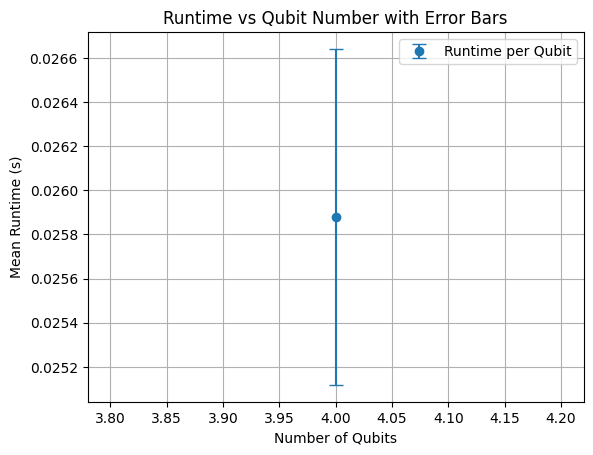

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import sem

qubits = 4
mean_runtime = np.mean(only_time_per_qubit)
error = sem(only_time_per_qubit)

plt.errorbar([qubits], [mean_runtime], yerr=[error], fmt='o', capsize=5, label='Runtime per Qubit')
plt.xlabel('Number of Qubits')
plt.ylabel('Mean Runtime (s)')
plt.title('Runtime vs Qubit Number with Error Bars')
plt.grid(True)
plt.legend()
plt.show()


Other Format Code (This time with a range of qubit values)

Upto 54 qubits data was saved, starting from the 56 qubits (to not fall behind any redundancies)

In [ ]:
import os
import json
import networkx as nx
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

# Folder to save runtime data
folder_name = "/content/drive/My Drive/MPS QAOA Results/Runtime_Modified_5_Runs"
os.makedirs(folder_name, exist_ok=True)  # Create folder if it doesn't exist

# For a range of qubit values
for values in range(39, 51):  # Qubits from 2 to 50
    for num in range(2, 5):  # 10 different generated graphs (Changed it into 3 diffrent graphs so that )
        binary = '00' * values
        n = len(binary)
        G = nx.random_regular_graph(3, n)
        layer_of_QAOA = 2
        edgelist = list(G.edges())

        # Run the circuit and collect runtime data
        runtime_data = lcr_qaoa_mps_run(binary, layer_of_QAOA, edgelist)

        # Process runtime data and save incrementally
        for entry in runtime_data:
            qubits = entry["qubits"]
            times = entry["times"]

            # File path for the current qubit count
            file_path = os.path.join(folder_name, f"{qubits}_qubits.json")

            # Load existing data if the file already exists
            if os.path.exists(file_path):
                with open(file_path, "r") as file:
                    existing_runtimes = json.load(file)
            else:
                existing_runtimes = []

            # Update the runtime data
            existing_runtimes.extend(times)

            # Save the updated data back to the file
            with open(file_path, "w") as file:
                json.dump(existing_runtimes, file)

        print(f"Runtime data for {values*2} qubits, graph {num} saved.")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Runtime data for 78 qubits, graph 2 saved.


/usr/local/lib/python3.10/dist-packages/quimb/tensor/decomp.py:347: UserWarning: Got: Internal algorithm failed to converge., falling back to scipy gesvd driver.
  warnings.warn(f"Got: {e}, falling back to scipy gesvd driver.")


Runtime data for 78 qubits, graph 3 saved.
Runtime data for 78 qubits, graph 4 saved.
Runtime data for 80 qubits, graph 2 saved.
Runtime data for 80 qubits, graph 3 saved.
Runtime data for 80 qubits, graph 4 saved.
Runtime data for 82 qubits, graph 2 saved.
Runtime data for 82 qubits, graph 3 saved.
Runtime data for 82 qubits, graph 4 saved.
Runtime data for 84 qubits, graph 2 saved.
Runtime data for 84 qubits, graph 3 saved.
Runtime data for 84 qubits, graph 4 saved.
Runtime data for 86 qubits, graph 2 saved.
Runtime data for 86 qubits, graph 3 saved.
Runtime data for 86 qubits, graph 4 saved.
Runtime data for 88 qubits, graph 2 saved.
Runtime data for 88 qubits, graph 3 saved.
Runtime data for 88 qubits, graph 4 saved.
Runtime data for 90 qubits, graph 2 saved.
Runtime data for 90 qubits, graph 3 saved.
Runtime data for 90 qubits, graph 4 saved.
Runtime data for 92 qubits, graph 2 saved.
Runtime data for 92 qubits, graph 3 saved.
Runtime data for 92 qubits, graph 4 saved.
Runtime dat

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


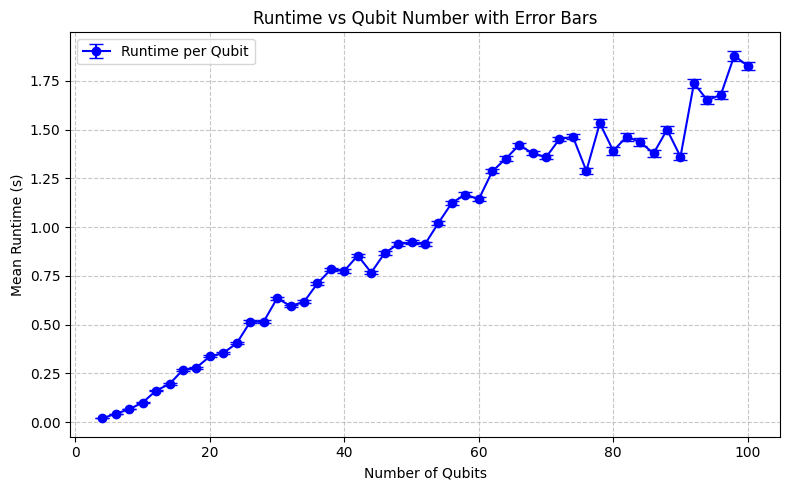

In [ ]:
import os
import json
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import sem
import os
import json
from google.colab import drive

drive.mount('/content/drive')

# Folder to save runtime data
folder_name = "/content/drive/My Drive/MPS QAOA Results/Runtime_Modified_5_Runs"

# Initialize lists for plotting
qubit_counts = []
mean_runtimes = []
errors = []

# Read JSON files from the folder
for file_name in os.listdir(folder_name):
    if file_name.endswith(".json"):
        qubit_count = int(file_name.split("_")[0])  # Extract qubit number from file name
        file_path = os.path.join(folder_name, file_name)

        # Load runtime data for this qubit number
        with open(file_path, "r") as file:
            runtimes = json.load(file)

        # Calculate mean and SEM
        mean_runtime = np.mean(runtimes)
        error = sem(runtimes)

        # Store data for plotting
        qubit_counts.append(qubit_count)
        mean_runtimes.append(mean_runtime)
        errors.append(error)

# Sort data by qubit counts (optional, for better visualization)
sorted_indices = np.argsort(qubit_counts)
qubit_counts = np.array(qubit_counts)[sorted_indices]
mean_runtimes = np.array(mean_runtimes)[sorted_indices]
errors = np.array(errors)[sorted_indices]

# Plot
plt.figure(figsize=(8, 5))
plt.errorbar(
    qubit_counts,
    mean_runtimes,
    yerr=errors,
    fmt='o-',
    capsize=5,
    label='Runtime per Qubit',
    color='blue'
)
plt.xlabel('Number of Qubits')
plt.ylabel('Mean Runtime (s)')
plt.title('Runtime vs Qubit Number with Error Bars')
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
plt.tight_layout()
plt.show()

# Regular QAOA Runtime v/s Qubit Count

Functions shifted to the main function section

In [ ]:
import os
import json
import numpy as np

# Mount Google Drive
drive.mount('/content/drive')

# Folder to save runtime data
folder_name = "/content/drive/My Drive/MPS QAOA Results/Runtime_Regular_5_Runs"
os.makedirs(folder_name, exist_ok=True)  # Create folder if it doesn't exist

# Dictionary to store qubit number as key and runtimes as values
qubit_runtime_dict = {}

# Running the whole process for different qubit numbers and graphs
for values in range(8, 51):
    for num in range(2, 5):  # Range of qubits
        binary = '00' * values
        n = len(binary)
        G = nx.random_regular_graph(3, n)
        layer_of_QAOA = 2
        edgelist = [i for i in G.edges()]

        # Run the regular QAOA MPS and collect runtime data
        runtime_data = regular_qaoa_mps_run(binary, layer_of_QAOA, edgelist)

        # Extract qubit number and times from runtime data
        for entry in runtime_data:
            qubits = entry['qubits']
            times = entry['times']

            # Add runtimes to the dictionary
            if qubits not in qubit_runtime_dict:
                qubit_runtime_dict[qubits] = []
            qubit_runtime_dict[qubits].extend(times)

        # Save runtime data to individual JSON files
        for qubits, runtimes in qubit_runtime_dict.items():
            file_path = os.path.join(folder_name, f"{qubits}_qubits.json")
            with open(file_path, "w") as file:
                json.dump(runtimes, file)

        print(f"Runtime data for {values*2} qubits, graph {num} saved.")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Plotting (Used std instead of sem method)

Mounted at /content/drive


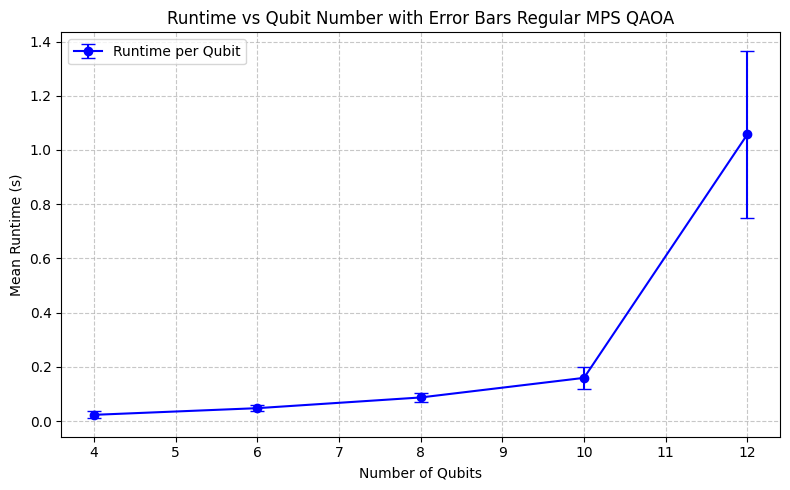

In [ ]:
import os
import json
import matplotlib.pyplot as plt
import numpy as np
import os
import json
from google.colab import drive
# from scipy.stats import sem

drive.mount('/content/drive')

# Folder to save runtime data
folder_name = "/content/drive/My Drive/MPS QAOA Results/Runtime_Regular_5_Runs"

# Initialize lists for plotting
qubit_counts = []
mean_runtimes = []
errors = []

# Read JSON files from the folder
for file_name in os.listdir(folder_name):
    if file_name.endswith(".json"):
        qubit_count = int(file_name.split("_")[0])  # Extract qubit number from file name
        file_path = os.path.join(folder_name, file_name)

        # Load runtime data for this qubit number
        with open(file_path, "r") as file:
            runtimes = json.load(file)

        # Calculate mean and SEM
        mean_runtime = np.mean(runtimes)
        error = np.std(runtimes)

        # Store data for plotting
        qubit_counts.append(qubit_count)
        mean_runtimes.append(mean_runtime)
        errors.append(error)

# Sort data by qubit counts (optional, for better visualization)
sorted_indices = np.argsort(qubit_counts)
qubit_counts = np.array(qubit_counts)[sorted_indices]
mean_runtimes = np.array(mean_runtimes)[sorted_indices]
errors = np.array(errors)[sorted_indices]

# Plot
plt.figure(figsize=(8, 5))
plt.errorbar(
    qubit_counts,
    mean_runtimes,
    yerr=errors,
    fmt='o-',
    capsize=5,
    label='Runtime per Qubit',
    color='blue'
)
plt.xlabel('Number of Qubits')
plt.ylabel('Mean Runtime (s)')
plt.title('Runtime vs Qubit Number with Error Bars Regular MPS QAOA')
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
plt.tight_layout()
plt.show()

# Tensors Dropped V/s the Qubit Counts (Modiified MPS QAOA and Regular MPS QAOA difference in percentage format)

MODIFIED

In [ ]:
import os
import json
import numpy as np
import networkx as nx


from google.colab import drive
drive.mount('/content/drive')
folder_name = "/content/drive/My Drive/MPS QAOA Results/Tensor_Count_Modified"
os.makedirs(folder_name, exist_ok=True)

qubit_tensor_dict_lcr = {}

for values in range(2, 51):  # For the range of qubits
    for i in range(2, 11):  # For different Generated Graphs
        binary = '00' * values
        n = len(binary)
        G = nx.random_regular_graph(3, n)
        edgelist = [i for i in G.edges()]
        layer_of_QAOA = 2

        tensor_counts = count_tensors_per_local_node(binary, layer_of_QAOA, edgelist)

        tensor_counts_str_keys = {str(key): value for key, value in tensor_counts.items()}

        # Store tensor counts for each graph (i) and qubit number (n)
        if n not in qubit_tensor_dict_lcr:
            qubit_tensor_dict_lcr[n] = {}

        qubit_tensor_dict_lcr[n][i] = tensor_counts_str_keys

        # Save tensor counts for each graph (i) in a separate file for each qubit number (n)
        file_path = os.path.join(folder_name, f"{n}_qubits_graph_{i}_tensor_count.json")

        with open(file_path, "w") as file:
            json.dump(tensor_counts_str_keys, file)

print(f"Tensor count data saved in folder: {folder_name}")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Tensor count data saved in folder: /content/drive/My Drive/MPS QAOA Results/Tensor_Count_Modified


REGULAR

In [ ]:
import os
import json
import numpy as np
import networkx as nx
import quimb as qtn
import quimb.tensor as qtn
import quimb

from google.colab import drive
drive.mount('/content/drive')
folder_name = "/content/drive/My Drive/MPS QAOA Results/Tensor_Count_Regular"
os.makedirs(folder_name, exist_ok=True)

qubit_tensor_dict_regular = {}

def lcr_qaoa_mps_tensor(binary, layer_of_QAOA, gamma, beta):
    q = qtn.MPS_computational_state(binary, dtype='float64', cyclic=False)
    n = len(binary)
    H = quimb.hadamard()
    for i in range(n):
        q.gate_(H, i, tags=f'H_{i}', contract=False)
    for l in range(layer_of_QAOA):
        for i in range(n):
            RX_beta = quimb.Rx(beta[l])
            q.gate_(RX_beta, i, tags=f'RX_{i}_L{l}', contract=False)
        for (i, j) in edgelist:
            RZZ_gamma = rzz(gamma[l])
            q.gate_(RZZ_gamma, (i, j), tags=f'RZZ_{i}_{j}_L{l}', contract=False)
    return q

def count_tensors_regular_qaoa(binary, layer_of_QAOA, edgelist):
    n = len(binary)
    gamma = [np.random.rand() for _ in range(layer_of_QAOA)]
    beta = [np.random.rand() for _ in range(layer_of_QAOA)]
    tensor_counts = {}
    for local_node in edgelist:
        q = lcr_qaoa_mps_tensor(binary, layer_of_QAOA, gamma, beta)
        tensor_counts[local_node] = len(q.tensors)
    return tensor_counts

for values in range(2, 51):
    for i in range(2, 11):
        binary = '00' * values
        n = len(binary)
        G = nx.random_regular_graph(3, n)
        edgelist = [i for i in G.edges()]
        layer_of_QAOA = 2
        tensor_counts = count_tensors_regular_qaoa(binary, layer_of_QAOA, edgelist)
        tensor_counts_str_keys = {str(key): value for key, value in tensor_counts.items()}
        if n not in qubit_tensor_dict_regular:
            qubit_tensor_dict_regular[n] = {}
        qubit_tensor_dict_regular[n][i] = tensor_counts_str_keys
        file_path = os.path.join(folder_name, f"{n}_qubits_graph_{i}_tensor_count.json")
        with open(file_path, "w") as file:
            json.dump(tensor_counts_str_keys, file)

print(f"Tensor count data saved in folder: {folder_name}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Tensor count data saved in folder: /content/drive/My Drive/MPS QAOA Results/Tensor_Count_Regular


Plotting the values with the percentage drop against the

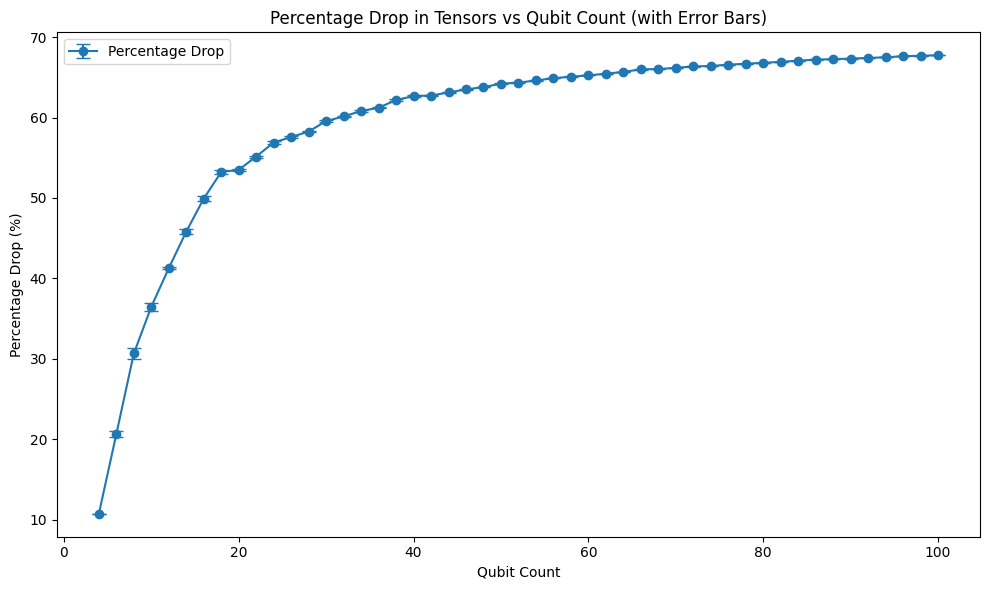

In [ ]:
import os
import json
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import sem

folder_modified = "/content/drive/My Drive/MPS QAOA Results/Tensor_Count_Modified"
folder_general = "/content/drive/My Drive/MPS QAOA Results/Tensor_Count_Regular"

if not os.path.exists(folder_modified) or not os.path.exists(folder_general):
    raise FileNotFoundError("One or both result folders do not exist!")

def load_tensor_counts(folder_name):
    tensor_data = {}
    for file_name in os.listdir(folder_name):
        if file_name.endswith(".json"):
            qubit_count = int(file_name.split("_")[0])
            with open(os.path.join(folder_name, file_name), "r") as file:
                tensor_data[qubit_count] = json.load(file)
    return tensor_data

modified_data = load_tensor_counts(folder_modified)
general_data = load_tensor_counts(folder_general)

qubit_counts = sorted(modified_data.keys())
average_drops = []
error_bars = []

for qubit_count in qubit_counts:
    modified_tensors = np.array(list(modified_data[qubit_count].values()), dtype=float)
    general_tensors = np.array(list(general_data[qubit_count].values()), dtype=float)
    percentage_drop = ((general_tensors - modified_tensors) / general_tensors) * 100
    mean_drop = np.mean(percentage_drop)
    sem_drop = sem(percentage_drop)
    average_drops.append(mean_drop)
    error_bars.append(sem_drop)

plt.figure(figsize=(10, 6))
plt.errorbar(
    qubit_counts, average_drops, yerr=error_bars, fmt="o-", capsize=5, label="Percentage Drop"
)
plt.title("Percentage Drop in Tensors vs Qubit Count (with Error Bars)")
plt.xlabel("Qubit Count")
plt.ylabel("Percentage Drop (%)")
plt.legend()
plt.tight_layout()
plt.show()

# MAX BOND COUNT V/S QUBIT COUNT

REGULAR

Due to an issue in naming, results from 4 qubits to 10 qubits are interchanged with that of the modified one

In [ ]:
import os
import json
import numpy as np
import networkx as nx
import quimb
import quimb.tensor as qtn


#Mount my Google drive
from google.colab import drive
drive.mount('/content/drive')
folder_name = "/content/drive/My Drive/MPS QAOA Results/Max_Bond_Regular"  # Change this path as needed
os.makedirs(folder_name, exist_ok=True)

# Function to generate an MPS with the regular QAOA method
def regular_qaoa_mps(binary, layer_of_QAOA, gamma, beta, edgelist):
    q = qtn.MPS_computational_state(binary, dtype='float64', cyclic=False)
    n = len(binary)
    H = quimb.hadamard()

    # Apply Hadamard gates
    for i in range(n):
        q.gate_(H, i, tags=f'H_{i}', contract=True)

    # Apply QAOA layers
    for l in range(layer_of_QAOA):
        RZZ_gamma = rzz(gamma[l])
        RX_beta = quimb.Rx(beta[l])

        # Problem Hamiltonian
        for (i, j) in edgelist:
            q.gate_(RZZ_gamma, (i, j), tags=f'RZZ_{i}_{j}_L{l}', contract='swap+split')

        # Mixer Hamiltonian
        for i in range(n):
            q.gate_(RX_beta, i, tags=f'RX_{i}_L{l}', contract=True)

    return q

# Define the RZZ gate
def rzz(gamma):
    return np.diag(np.array([np.exp(-1.j * gamma) / 2, np.exp(-1.j * gamma) / 2,
                             np.exp(-1.j * gamma) / 2, -np.exp(-1.j * gamma) / 2]))

# Function to calculate and save max bond dimensions for regular QAOA
def calculate_max_bond_regular_qaoa(binary, layer_of_QAOA, edgelist):
    n = len(binary)
    gamma = [np.random.rand() for _ in range(layer_of_QAOA)]
    beta = [np.random.rand() for _ in range(layer_of_QAOA)]
    max_bond_data = {}

    # Generate the MPS for QAOA
    for local_node in edgelist:

      q = regular_qaoa_mps(binary, layer_of_QAOA, gamma, beta, edgelist)

      max_bond_data[local_node] = q.max_bond()
    return max_bond_data

# Dictionary to store max bond data
qubit_max_bond_dict = {}

# Loop over qubit counts and graph instances
for values in range(2, 101):
    for i in range(2, 11):
        binary = '00'*values
        n = len(binary)
        G = nx.random_regular_graph(3, n)
        edgelist = list(G.edges)
        layer_of_QAOA = 2
        max_bond = calculate_max_bond_regular_qaoa(binary, layer_of_QAOA, edgelist)
        if n not in qubit_max_bond_dict:
            qubit_max_bond_dict[n] = {}
        qubit_max_bond_dict[n][i] = max_bond
        file_path = os.path.join(folder_name, f"{n}_qubits_graph_{i}_max_bond.json")
        max_bond_serializable = {str(k): v for k, v in max_bond.items()}  # Convert tuple keys to strings
        with open(file_path, "w") as file:
            json.dump({"max_bond": max_bond_serializable}, file)

print(f"Max bond data saved in folder: {folder_name}")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


/usr/local/lib/python3.10/dist-packages/quimb/tensor/decomp.py:347: UserWarning: Got: Internal algorithm failed to converge., falling back to scipy gesvd driver.
  warnings.warn(f"Got: {e}, falling back to scipy gesvd driver.")


MODIFIED

In [ ]:
import numpy as np
import quimb
import quimb.tensor as qtn
import networkx as nx
import json
import os

def lcr_qaoa_mps_max_bond(binary, layer_of_QAOA, filtered_gates, gamma, beta):
    q = qtn.MPS_computational_state(binary, dtype='float64', cyclic=False)
    n = len(binary)
    H = quimb.hadamard()
    for i in range(n):
        q.gate_(H, i, tags=f'H_{i}', contract=True)
    for l in range(layer_of_QAOA):
        for gate in filtered_gates:
            if gate[2] == l:
                if gate[0] == 'RZZ':
                    i, j = gate[1]
                    RZZ_gamma = rzz(gamma[l])
                    q.gate_(RZZ_gamma, (i, j), tags=f'RZZ_{i}_{j}_L{l}', contract='swap+split')
                elif gate[0] == 'RX':
                    i = gate[1]
                    RX_beta = quimb.Rx(beta[l])
                    q.gate_(RX_beta, i, tags=f'RX_{i}_L{l}', contract=True)
    return q

def calculate_max_bond_modified_qaoa(binary, layer_of_QAOA, edgelist, Drop_Gates_LCRM):
    n = len(binary)
    gamma = [np.random.rand() for _ in range(layer_of_QAOA)]
    beta = [np.random.rand() for _ in range(layer_of_QAOA)]
    max_bond_data = {}
    for local_node in edgelist:
        filtered_gates = []
        excluded_gates = Drop_Gates_LCRM(local_node, edgelist, layer_of_QAOA, n)
        for layer in range(layer_of_QAOA):
            for (i, j) in edgelist:
                if f'RZZ({i}, {j})' not in excluded_gates[layer]:
                    filtered_gates.append(('RZZ', (i, j), layer))
            for i in range(n):
                if f'RX({i})' not in excluded_gates[layer]:
                    filtered_gates.append(('RX', i, layer))
        q = lcr_qaoa_mps_max_bond(binary, layer_of_QAOA, filtered_gates, gamma, beta)
        max_bond_data[local_node] = q.max_bond()
    return max_bond_data

qubit_max_bond_dict = {}

#Mount my Google drive
from google.colab import drive
drive.mount('/content/drive')
folder_name = "/content/drive/My Drive/MPS QAOA Results/Max_Bond_Modified"  # Change this path as needed
os.makedirs(folder_name, exist_ok=True)

for values in range(42, 101):
    for i in range(2, 11):
        binary = '0' * (2 * values)
        n = len(binary)
        G = nx.random_regular_graph(3, n)
        edgelist = list(G.edges)
        layer_of_QAOA = 2
        max_bond = calculate_max_bond_modified_qaoa(binary, layer_of_QAOA, edgelist, Drop_Gates_LCRM)
        if n not in qubit_max_bond_dict:
            qubit_max_bond_dict[n] = {}
        qubit_max_bond_dict[n][i] = max_bond
        file_path = os.path.join(folder_name, f"{n}_qubits_graph_{i}_max_bond.json")
        max_bond_serializable = {str(k): v for k, v in max_bond.items()}  # Convert tuple keys to strings
        with open(file_path, "w") as file:
            json.dump({"max_bond": max_bond_serializable}, file)

print(f"Max bond data saved in folder: {folder_name}")


The plotting

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


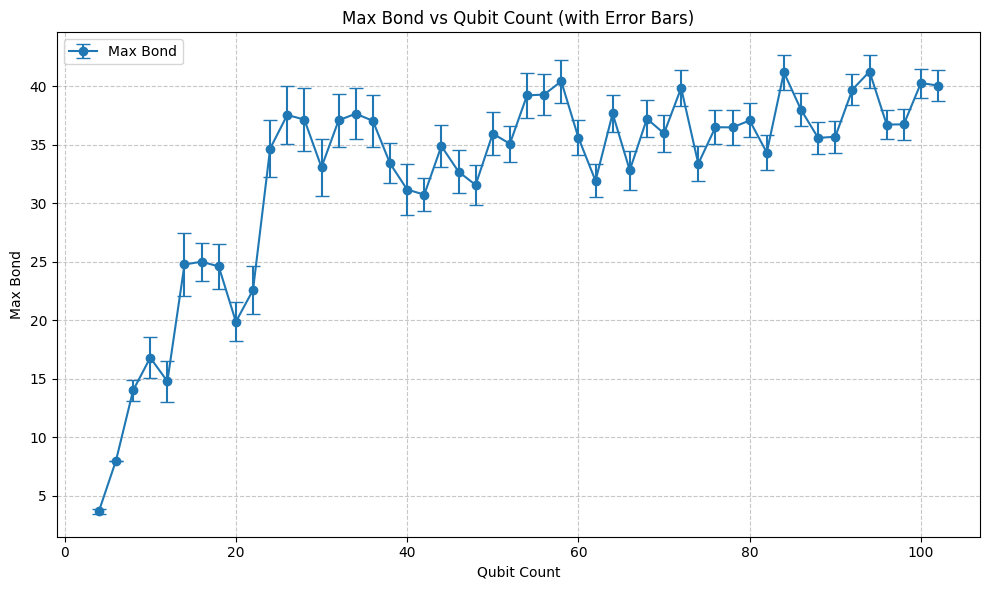

In [ ]:
import os
import json
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import sem

# Path to the folder containing the modified data
from google.colab import drive
drive.mount('/content/drive')
folder_modified = "/content/drive/My Drive/MPS QAOA Results/Max_Bond_Modified"

# Ensure the folder exists
if not os.path.exists(folder_modified):
    raise FileNotFoundError("The folder for modified data does not exist!")

# Function to load max bond data from JSON files
def load_max_bond_data(folder_name):
    max_bond_data = {}
    for file_name in os.listdir(folder_name):
        if file_name.endswith(".json"):
            qubit_count = int(file_name.split("_")[0])  # Assuming filenames start with qubit count
            with open(os.path.join(folder_name, file_name), "r") as file:
                data = json.load(file)
                max_bond_data[qubit_count] = list(data["max_bond"].values())
    return max_bond_data

# Load the data from the folder
modified_data = load_max_bond_data(folder_modified)

# Prepare data for plotting
qubit_counts = sorted(modified_data.keys())
average_bonds = []
error_bars = []

for qubit_count in qubit_counts:
    bond_values = np.array(modified_data[qubit_count], dtype=float)
    mean_bond = np.mean(bond_values)
    sem_bond = sem(bond_values)  # Standard Error of the Mean
    average_bonds.append(mean_bond)
    error_bars.append(sem_bond)

# Plotting the error bar graph
plt.figure(figsize=(10, 6))
plt.errorbar(
    qubit_counts, average_bonds, yerr=error_bars, fmt="o-", capsize=5, label="Max Bond"
)
plt.title("Max Bond vs Qubit Count (with Error Bars)")
plt.xlabel("Qubit Count")
plt.ylabel("Max Bond")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()